In [1]:
import os
from tqdm.notebook import tqdm
import json

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import json
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

from src.utils import create_edge_index, PLIDataset, set_all_seeds, GCN, save_model
from src.edgeshaper import Edgeshaper

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
set_all_seeds(42)

In [3]:
DATA_PATH = 'data/pdbbind/dataset/'
SAVE_FOLDER = 'results/explanations/'

## EDA

read mol2 files

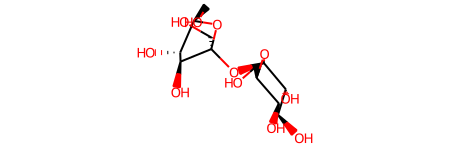

In [4]:
target_mol_name = "1a0t"
mol = Chem.MolFromMol2File(DATA_PATH + target_mol_name + "/" + target_mol_name + "_ligand.mol2")
test_mol = Draw.PrepareMolForDrawing(mol)
test_mol


In [5]:
num_bonds = len(test_mol.GetBonds())
num_atoms = len(test_mol.GetAtoms())

print("Number of bonds: ", num_bonds)
print("Number of atoms: ", num_atoms)

rdkit_bonds = {}

for i in range(num_bonds):
    init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
    end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
    bond_type = test_mol.GetBondWithIdx(i).GetBondType()
    print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
    rdkit_bonds[(init_atom, end_atom)] = i
    #CNC(=O)CN1CN(c2ccccc2)C2(CCN(Cc3cc4c(cc3Cl)OCO4)CC2)C1=O
# rdkit_bonds

Number of bonds:  24
Number of atoms:  23
Bond:  0   0 - 1   SINGLE
Bond:  1   0 - 6   SINGLE
Bond:  2   0 - 10   SINGLE
Bond:  3   1 - 2   SINGLE
Bond:  4   1 - 7   SINGLE
Bond:  5   2 - 3   SINGLE
Bond:  6   2 - 8   SINGLE
Bond:  7   3 - 4   SINGLE
Bond:  8   3 - 9   SINGLE
Bond:  9   4 - 5   SINGLE
Bond:  10   4 - 10   SINGLE
Bond:  11   5 - 11   SINGLE
Bond:  12   6 - 13   SINGLE
Bond:  13   13 - 12   SINGLE
Bond:  14   12 - 18   SINGLE
Bond:  15   13 - 14   SINGLE
Bond:  16   13 - 19   SINGLE
Bond:  17   14 - 15   SINGLE
Bond:  18   14 - 20   SINGLE
Bond:  19   15 - 16   SINGLE
Bond:  20   15 - 21   SINGLE
Bond:  21   16 - 17   SINGLE
Bond:  22   16 - 19   SINGLE
Bond:  23   17 - 22   SINGLE


read json interaction graph

In [6]:
with open(DATA_PATH + target_mol_name + "/" + target_mol_name + "_interaction_graph.json", 'r') as f:
  data = json.load(f)

print("Number of atoms: ", len(data['nodes']))
print("Number of bonds: ", len(data['edges']))

Number of atoms:  45
Number of bonds:  1024


In [7]:
print(data['nodes'])

[{'id': 0, 'attype': 'N', 'pl': 'L'}, {'id': 1, 'attype': 'N', 'pl': 'L'}, {'id': 2, 'attype': 'N', 'pl': 'L'}, {'id': 3, 'attype': 'N', 'pl': 'L'}, {'id': 4, 'attype': 'N', 'pl': 'L'}, {'id': 5, 'attype': 'N', 'pl': 'L'}, {'id': 6, 'attype': 'N', 'pl': 'L'}, {'id': 7, 'attype': 'N', 'pl': 'L'}, {'id': 8, 'attype': 'N', 'pl': 'L'}, {'id': 9, 'attype': 'N', 'pl': 'L'}, {'id': 10, 'attype': 'N', 'pl': 'L'}, {'id': 11, 'attype': 'O', 'pl': 'L'}, {'id': 12, 'attype': 'O', 'pl': 'L'}, {'id': 13, 'attype': 'O', 'pl': 'L'}, {'id': 14, 'attype': 'O', 'pl': 'L'}, {'id': 15, 'attype': 'O', 'pl': 'L'}, {'id': 16, 'attype': 'O', 'pl': 'L'}, {'id': 17, 'attype': 'O', 'pl': 'L'}, {'id': 18, 'attype': 'O', 'pl': 'L'}, {'id': 19, 'attype': 'CA', 'pl': 'L'}, {'id': 20, 'attype': 'CA', 'pl': 'L'}, {'id': 21, 'attype': 'CA', 'pl': 'L'}, {'id': 22, 'attype': 'CA', 'pl': 'L'}, {'id': 23, 'attype': 'CA', 'pl': 'L'}, {'id': 24, 'attype': 'CA', 'pl': 'L'}, {'id': 25, 'attype': 'CA', 'pl': 'L'}, {'id': 26, 'at

Visualize interaction graph - red atoms from Protein and lightblue atoms from Ligand

In [8]:
G = nx.Graph()

for edge in data['edges']:
    if edge["id1"] != None and edge["id2"] != None:
        G.add_edge(edge["id1"], edge["id2"], weight=edge["length"])

for node in data['nodes']:
    nx.set_node_attributes(G, {node["id"]: node["attype"]}, "atom_type")
    nx.set_node_attributes(G, {node["id"]: node["pl"]}, "from")

print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

colors = ["red" if G.nodes[node]["from"] == "P" else "lightblue" for node in G.nodes]

# nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True, font_weight='bold', labels=nx.get_node_attributes(G, 'atom_type'), node_color=colors)
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

Number of nodes:  45
Number of edges:  247


#### Gather affinity values

## Load dataset

#### Load affinities
Already save in JSON, can load them

In [9]:
# directory = os.fsencode(DATA_PATH)

# data_versions = [2020, 2019, 2016]
# interaction_affinities = {}

# for file in tqdm(os.listdir(directory)):
#     interaction_name = os.fsdecode(file)
#     if os.path.isdir(DATA_PATH + interaction_name):
#         for version in data_versions:
#             INDEX_PATH = "data/pdbbind/PDBbind_v" + str(version) + "_plain_text_index/index/INDEX_general_PL_data." + str(version)
#             with open(INDEX_PATH, 'r') as f:
#                 interaction_info = f.readlines()[5:]
#                 for line in interaction_info:
#                     row = line.strip().split(" ")
#                     if row[0] == interaction_name:
#                         row = list(filter(lambda a: a != "", row)) #remove empty strings
                        
#                         affinity = float(row[3])
                        
#                         interaction_affinities[interaction_name] = affinity
#                         break

# with open(DATA_PATH + '/interaction_affinities.json', 'w+') as fp:
#     json.dump(interaction_affinities, fp, sort_keys=True, indent=4)            

In [10]:
interaction_affinities = None

with open(DATA_PATH + '/interaction_affinities.json', 'r') as fp:
    interaction_affinities = json.load(fp)

In [11]:
def generate_pli_dataset_dict(data_path):

    directory = os.fsencode(data_path)

    dataset_dict = {}
    dirs = os.listdir(directory)
    for file in tqdm(dirs):
        interaction_name = os.fsdecode(file)
        if os.path.isdir(data_path + interaction_name):
            dataset_dict[interaction_name] = {}
            with open(data_path + interaction_name + "/" + interaction_name + "_interaction_graph.json", 'r') as f:
                data = json.load(f)
                G = nx.Graph()

                for edge in data['edges']:
                    if edge["id1"] != None and edge["id2"] != None:
                        G.add_edge(edge["id1"], edge["id2"], weight=edge["length"])

                for node in data['nodes']:
                    nx.set_node_attributes(G, {node["id"]: node["attype"]}, "atom_type")
                    nx.set_node_attributes(G, {node["id"]: node["pl"]}, "from")

                # print(nx.to_scipy_sparse_matrix(G).tocoo())
                
            dataset_dict[interaction_name]["networkx_graph"] = G
            edge_index, edge_weight = create_edge_index(G, weighted=True)

            dataset_dict[interaction_name]["edge_index"] = edge_index
            dataset_dict[interaction_name]["edge_weight"] = edge_weight
            # dataset_dict[interaction_name]["edge_weight"] = 

            num_nodes = G.number_of_nodes()
            dataset_dict[interaction_name]["x"] = torch.full((num_nodes, 1), 1.0, dtype=torch.float)#dummy feature

            ## gather label
            dataset_dict[interaction_name]["y"] = torch.FloatTensor([interaction_affinities[interaction_name]])
    
    return dataset_dict
        
pli_dataset_dict = generate_pli_dataset_dict(DATA_PATH)     

  0%|          | 0/14219 [00:00<?, ?it/s]

### create torch dataset

In [12]:
data_list = []
for interaction_name in tqdm(pli_dataset_dict):
    data_list.append(Data(x = pli_dataset_dict[interaction_name]["x"], edge_index = pli_dataset_dict[interaction_name]["edge_index"], edge_weight = pli_dataset_dict[interaction_name]["edge_weight"], y = pli_dataset_dict[interaction_name]["y"], networkx_graph = pli_dataset_dict[interaction_name]["networkx_graph"], interaction_name = interaction_name))

  0%|          | 0/14215 [00:00<?, ?it/s]

In [13]:
dataset = PLIDataset(".", data_list = data_list)

In [14]:
train_interactions = []
val_interactions = []
core_set_interactions = []
hold_out_interactions = []

with open("data/pdbbind/pdb_ids/training_set.csv", 'r') as f:
    train_interactions = f.readlines()

train_interactions = [interaction.strip() for interaction in train_interactions]

with open("data/pdbbind/pdb_ids/validation_set.csv", 'r') as f:
    val_interactions = f.readlines()

val_interactions = [interaction.strip() for interaction in val_interactions]

with open("data/pdbbind/pdb_ids/core_set.csv", 'r') as f:
    core_set_interactions = f.readlines()

core_set_interactions = [interaction.strip() for interaction in core_set_interactions]

with open("data/pdbbind/pdb_ids/hold_out_set.csv", 'r') as f:
    hold_out_interactions = f.readlines()

hold_out_interactions = [interaction.strip() for interaction in hold_out_interactions]

In [15]:
train_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in train_interactions]
val_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in val_interactions]
core_set_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in core_set_interactions]
hold_out_data = [dataset[i] for i in range(len(dataset)) if dataset[i].interaction_name in hold_out_interactions]

In [16]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
core_set_loader = DataLoader(core_set_data, batch_size=BATCH_SIZE)
hold_out_loader = DataLoader(hold_out_data, batch_size=BATCH_SIZE)


In [17]:
# num_classes  =  1 even for regression
model = GCN(node_features_dim = dataset[0].x.shape[1], num_classes = 1, hidden_channels=256).to(device)

In [18]:
model.load_state_dict(torch.load("models/model_2022_11_08-15_47_33.ckpt"))
model.to(device)
model

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(256, 1, bias=True)
)

### Train the network

In [19]:
#training the network
lr = lr=1e-3
EPOCHS = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

epochs = EPOCHS

In [20]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, edge_weight = data.edge_weight)  # Perform a single forward pass.
        loss = torch.sqrt(criterion(torch.squeeze(out), data.y))  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    sum_loss = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        
        out = model(data.x, data.edge_index, data.batch, edge_weight = data.edge_weight)  
        loss = torch.sqrt(criterion(torch.squeeze(out), data.y)) 
        sum_loss += loss.item()
    return sum_loss / len(loader.dataset)  # Derive ratio of correct predictions.

To train network, uncomment the cell below

In [21]:
# for epoch in range(epochs):
#     train()
#     train_rmse = test(train_loader)
#     val_rmse = test(val_loader)
#     print(f'Epoch: {epoch:03d}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

# core_set_rmse = test(core_set_loader)    
# print(f'Core set 2016 RMSE: {core_set_rmse:.4f}')

# hold_out_set_rmse = test(hold_out_loader)    
# print(f'Hold out set 2019 RMSE: {hold_out_set_rmse:.4f}')

# save_model(model, "models")

In [22]:
core_set_rmse = test(core_set_loader)    
print(f'Core set 2016 RMSE: {core_set_rmse:.4f}')

Core set 2016 RMSE: 0.0839


c:\Users\Mastro\anaconda3\envs\edgeshaper\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [23]:
hold_out_set_rmse = test(hold_out_loader)    
print(f'Hold out set 2019 RMSE: {hold_out_set_rmse:.4f}')

Hold out set 2019 RMSE: 0.0563


## Explainability

In [24]:
num_test_interactions = len(hold_out_interactions)
test_interaction_indices = np.random.choice(num_test_interactions, 10, replace=False)

num_edge_in_protein_list = []
num_edge_in_ligand_list = []
num_edge_in_between_list = []

In [25]:
for index in tqdm(test_interaction_indices):
    test_interaction = hold_out_data[index]
    print("Interaction: " + test_interaction.interaction_name)

    batch = torch.zeros(test_interaction.x.shape[0], dtype=int, device=test_interaction.x.device)
                
    out = model(test_interaction.x.to(device), test_interaction.edge_index.to(device), batch=batch.to(device), edge_weight=test_interaction.edge_weight.to(device))

    print(f"Predicted: {out.item()} Actual: {test_interaction.y.item()}")


    #explainability

    edgeshaper_explainer = Edgeshaper(model, test_interaction.x, test_interaction.edge_index, edge_weight = test_interaction.edge_weight, device = device)

    phi_edges = edgeshaper_explainer.explain(M = 100, target_class = None, deviation = 1e-3, seed = 42)

    print(f"Sum of phi edges: {sum(phi_edges)}")

    #plotting
    num_bonds = test_interaction.networkx_graph.number_of_edges()
    rdkit_bonds_phi = [0]*num_bonds
    rdkit_bonds = {}

    bonds = dict(test_interaction.networkx_graph.edges())
    bonds = list(bonds.keys())

    for i in range(num_bonds):
        init_atom = bonds[i][0]
        end_atom = bonds[i][1]
        
        rdkit_bonds[(init_atom, end_atom)] = i

    for i in range(len(phi_edges)):
        phi_value = phi_edges[i]
        init_atom = test_interaction.edge_index[0][i].item()
        end_atom = test_interaction.edge_index[1][i].item()
        
        if (init_atom, end_atom) in rdkit_bonds:
            bond_index = rdkit_bonds[(init_atom, end_atom)]
            rdkit_bonds_phi[bond_index] += phi_value
        if (end_atom, init_atom) in rdkit_bonds:
            bond_index = rdkit_bonds[(end_atom, init_atom)]
            rdkit_bonds_phi[bond_index] += phi_value

    # print(rdkit_bonds_phi)

    G = test_interaction.networkx_graph
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())

    colors = ["red" if G.nodes[node]["from"] == "P" else "lightblue" for node in G.nodes]

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, font_weight='bold', labels=nx.get_node_attributes(G, 'atom_type'), node_color=colors,edge_color=rdkit_bonds_phi, width=3, edge_cmap=plt.cm.bwr)

    plt.show()

    SAVE_PATH = SAVE_FOLDER + "/" + test_interaction.interaction_name + "/"

    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

    plt.savefig(SAVE_PATH + test_interaction.interaction_name + "_EdgeSHAPer.png")

    plt.close()

    ### statistics on important edges
    mean_phi = np.mean(rdkit_bonds_phi)
    top_edges = [i for i in range(len(rdkit_bonds_phi)) if rdkit_bonds_phi[i] >= mean_phi]

    num_edge_in_protein = 0
    num_edge_in_ligand = 0
    num_edge_in_between = 0

    atoms_origin = nx.get_node_attributes(G, 'from')

    for bond in bonds:
        init_atom = bond[0]
        end_atom = bond[1]

        bond_index = rdkit_bonds[(init_atom, end_atom)]
        if bond_index in top_edges:
            if atoms_origin[init_atom] == "P" and atoms_origin[end_atom] == "P":
                num_edge_in_protein += 1
            elif atoms_origin[init_atom] == "L" and atoms_origin[end_atom] == "L":
                num_edge_in_ligand += 1
            else:
                num_edge_in_between += 1

    with open(SAVE_PATH + test_interaction.interaction_name + "_statistics.txt", "w") as f:
        f.write("Number of relevant edges connecting protein atoms: " + str(num_edge_in_protein) + "\n")
        f.write("Number of relevant edges connecting ligand atoms: " + str(num_edge_in_ligand) + "\n")
        f.write("Number of relevant edges connecting protein and ligand atoms: " + str(num_edge_in_between) + "\n")

    num_edge_in_protein_list.append(num_edge_in_protein)
    num_edge_in_ligand_list.append(num_edge_in_ligand)
    num_edge_in_between_list.append(num_edge_in_between)

    print("Number of relevant edges connecting protein atoms: ", num_edge_in_protein)
    print("Number of relevant edges connecting ligand atoms: ", num_edge_in_ligand)
    print("Number of relevant edges connecting protein and ligand atoms: ", num_edge_in_between)



  0%|          | 0/10 [00:00<?, ?it/s]

Interaction: 4zj8
Predicted: 6.529644012451172 Actual: 9.260000228881836
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 0.9414651083946232
Number of nodes:  41
Number of edges:  133
Number of relevant edges connecting protein atoms:  3
Number of relevant edges connecting ligand atoms:  5
Number of relevant edges connecting protein and ligand atoms:  3
Interaction: 5y8w
Predicted: 6.448524475097656 Actual: 6.639999866485596
No target class specified. Regression model assumed.


C:\Users\Mastro\AppData\Local\Temp\ipykernel_3216\2991038405.py:58: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 1.3219738590717316
Number of nodes:  34
Number of edges:  136
Number of relevant edges connecting protein atoms:  2
Number of relevant edges connecting ligand atoms:  12
Number of relevant edges connecting protein and ligand atoms:  2
Interaction: 6f1n
Predicted: 6.536458969116211 Actual: 6.260000228881836
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 1.2904818463325503
Number of nodes:  39
Number of edges:  138
Number of relevant edges connecting protein atoms:  1
Number of relevant edges connecting ligand atoms:  9
Number of relevant edges connecting protein and ligand atoms:  5
Interaction: 5vfd
Predicted: 6.536458969116211 Actual: 6.440000057220459
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 0.5385151481628416
Number of nodes:  11
Number of edges:  27
Number of relevant edges connecting protein atoms:  0
Number of relevant edges connecting ligand atoms:  8
Number of relevant edges connecting protein and ligand atoms:  0
Interaction: 5jyo
Predicted: 6.534878730773926 Actual: 8.520000457763672
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 1.04589102268219
Number of nodes:  52
Number of edges:  177
Number of relevant edges connecting protein atoms:  2
Number of relevant edges connecting ligand atoms:  16
Number of relevant edges connecting protein and ligand atoms:  4
Interaction: 5nq5
Predicted: 6.229280948638916 Actual: 5.0
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 0.5769816064834595
Number of nodes:  39
Number of edges:  117
Number of relevant edges connecting protein atoms:  8
Number of relevant edges connecting ligand atoms:  62
Number of relevant edges connecting protein and ligand atoms:  37
Interaction: 5msb
Predicted: 6.5331878662109375 Actual: 7.460000038146973
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 1.4073828029632565
Number of nodes:  31
Number of edges:  119
Number of relevant edges connecting protein atoms:  2
Number of relevant edges connecting ligand atoms:  13
Number of relevant edges connecting protein and ligand atoms:  5
Interaction: 5tvn
Predicted: 5.015599250793457 Actual: 9.039999961853027
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: -0.8755006551742556
Number of nodes:  30
Number of edges:  71
Number of relevant edges connecting protein atoms:  1
Number of relevant edges connecting ligand atoms:  38
Number of relevant edges connecting protein and ligand atoms:  25
Interaction: 5tqg
Predicted: 6.536458969116211 Actual: 9.619999885559082
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 1.5914639210701003
Number of nodes:  56
Number of edges:  248
Number of relevant edges connecting protein atoms:  0
Number of relevant edges connecting ligand atoms:  14
Number of relevant edges connecting protein and ligand atoms:  7
Interaction: 6f1x
Predicted: 5.902372360229492 Actual: 7.699999809265137
No target class specified. Regression model assumed.


  0%|          | 0/100 [00:00<?, ?it/s]

Sum of phi edges: 0.1633791136741639
Number of nodes:  29
Number of edges:  83
Number of relevant edges connecting protein atoms:  2
Number of relevant edges connecting ligand atoms:  53
Number of relevant edges connecting protein and ligand atoms:  23


In [26]:
print("Avg number of edges in protein: ", round(np.mean(num_edge_in_protein_list), 3))
print("Avg number of edges in ligand: ", round(np.mean(num_edge_in_ligand_list), 3))
print("Avg number of edges in between: ", round(np.mean(num_edge_in_between_list), 3))

Avg number of edges in protein:  2.1
Avg number of edges in ligand:  23.0
Avg number of edges in between:  11.1


In [27]:
with open(SAVE_FOLDER + "/statistics.txt", "w") as f:
    f.write("Avg number of edges in protein: " + str(round(np.mean(num_edge_in_protein_list), 3)) + "\n")
    f.write("Avg number of edges in ligand: " + str(round(np.mean(num_edge_in_ligand_list), 3)) + "\n")
    f.write("Avg number of edges in between: " + str(round(np.mean(num_edge_in_between_list), 3)) + "\n")